In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.resnet import ResNetVAE
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/small_sim_recs"
IMAGE_RESIZE = 32
LATENT_DIM = 16
DATAPOINT_COUNT = 200
AE_PATH = "./logs/models/VAE_2024-10-25_16:30/pth/epoch_400.pth"
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Using cpu


In [4]:
# Create the input data: latent representation of initial scene images
X = []
for i, im_path in tqdm(enumerate(im_paths)):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW
    X.append(image)
    if i == DATAPOINT_COUNT-1: break

X = np.array(X)
print(X.shape)

199it [00:00, 991.79it/s] 

(200, 3, 32, 32)


In [ ]:
# Create output data: waypoint collections from the paths
ways = []
for i, ep_path in tqdm(enumerate(dirs)):
    if i == DATAPOINT_COUNT-1: break
    pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
    ways.append(pickplace_task_waypoints(pos, gripper_widths))
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
print(y.shape)

(200, 9)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [ ]:
import json
import torch.nn as nn
from datetime import datetime


class MLPdc(nn.Module):
  
    def __init__(self, input_dim: int, output_dim: int, hidden_layers: list[int]=[256, 256, 256]):
        super(MLPdc, self).__init__()
        layers = []
        self.output_dim = output_dim
        last_dim = input_dim + output_dim + 1
        for size in hidden_layers:
            layers.append(nn.Linear(last_dim, size))
            layers.append(nn.ReLU())
            last_dim = size

        layers.append(nn.Linear(last_dim, output_dim))

        self.layers = nn.Sequential(*layers)

        self.model_params = {
            'input_size': input_dim,
        }

        self.path = "."

    def generate_log_data_path(self):
        current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")
        self.path = f"./logs/models/diffuser-mlp_{current_time}"
        if not os.path.exists(f"{self.path}/pth"):
            os.makedirs(f"{self.path}/pth")

    def log_model(self):
        self.generate_log_data_path()
        with open(f'{self.path}/model_params.json', 'w', encoding='utf-8') as f:
            json.dump(self.model_params, f)
    
    def save(self, epoch: int):
        file_name = f"{self.path}/pth/epoch_{epoch}.pth"
        torch.save(self.state_dict(), file_name)

    def forward(self, c, x, t):
        x = torch.concat([x, c, t], axis=-1)
        x = self.layers(x)
        return x
    
    def sample(self, conditioning: np.ndarray, device: str, n_steps: int=100):
        n_samples = conditioning.shape[0]
        x_t = torch.randn((n_samples, self.output_dim)).to(device)
        
        for i in range(n_steps):
            x_t += torch.randn((n_samples, self.output_dim)).to(device) * .001

            # t = torch.zeros((n_samples, 1)).to(device) + i / n_steps
            t = torch.ones((n_samples, 1)).to(device)

            noise_prediction = self(conditioning, x_t, t)
            # noise_prediction /= n_steps - i
            noise_prediction /= n_steps
            x_t -= noise_prediction

        return x_t

In [ ]:
encoder = ResNetVAE(latent_dim=LATENT_DIM, in_channels=3).to(device=device)
mlp_model = MLPdc(LATENT_DIM, y_train.shape[1], hidden_layers=[256, 128]).to(device)

lr=1e-4
n_epochs=2_000

optimizer = torch.optim.Adam(
    list(mlp_model.parameters()) + list(encoder.parameters()),
    lr=lr
)

mlp_model.to(device)
encoder.to(device)
train_losses = []
val_losses = []
loss_fn = nn.MSELoss()

for epoch in range(n_epochs):
    
    # Train step
    encoder.train()
    mlp_model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        X, _ = encoder.encode(X)  # Encode input

        # Fwd pass
        with torch.no_grad():
            t = torch.rand(size=(y.shape[0], 1), device=device)
            noise = torch.randn(*y.shape, device=device)
            model_in = y * t + noise * ( torch.ones(size=(y.shape[0], 1), device=device) - t )
            
        out = mlp_model(X, model_in, t)
        loss = loss_fn(noise, out)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Print losses for this epoch
    print(f"Epoch {epoch + 1},\t Train Loss: {train_loss:.6f},\t")

In [22]:
for i in range(2):
    if i:
        latent_images, _ = encoder.encode(torch.Tensor(X_test).to(device))
        y_pred = mlp_model.sample(latent_images, device).cpu().detach().numpy()
        errors = y_test - y_pred
    else:
        latent_images, _ = encoder.encode(torch.Tensor(X_train).to(device))
        y_pred = mlp_model.sample(latent_images, device).cpu().detach().numpy()
        errors = y_train - y_pred
    
    errors = errors[:, :2]
    errors = [np.linalg.norm(e) for e in errors]
    mean_error = sum(errors)/len(errors)
    devs = [abs(e-mean_error) for e in errors]
    dev_error = sum(devs)/len(devs)

    max_error = .015
    total_wins = 0
    for e in errors:
        if e < max_error:
            total_wins += 1

    if i:
        print("Test avg. dist. from desired point (m): ", mean_error)
        print("Test avg. dev. from desired point (m): ", dev_error)
        print(f"Success rate: {(total_wins/len(errors)*100):.2f}%")
    else:
        print("Train avg. dist. from desired point (m): ", mean_error)
        print("Train avg. dev. from desired point (m): ", dev_error)
    print("+--------------------------------------------------------------+")

torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16])
torch.Size([160, 1])
torch.Size([160, 9])
torch.Size([160, 16

torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6, 9])
torch.Size([6, 16])
torch.Size([6, 1])
torch.Size([6,

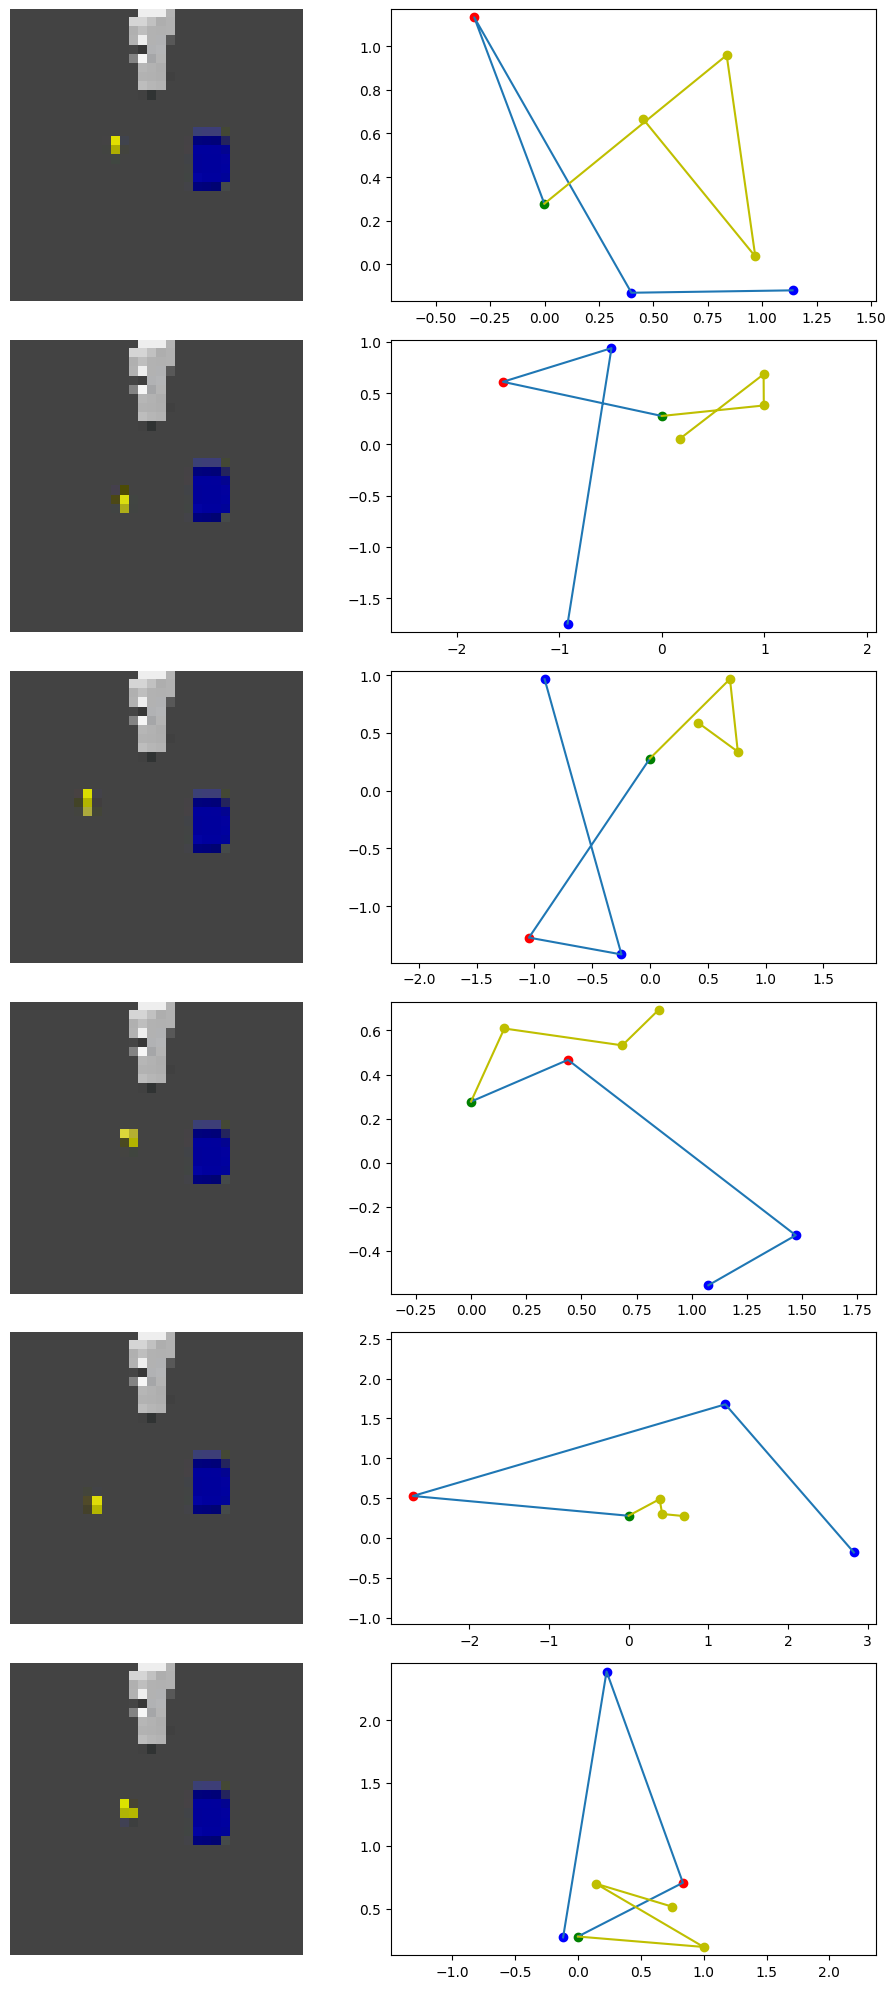

In [25]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

imgs = X_test[rand_indices]

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)

latent_images, _ = encoder.encode(torch.Tensor(imgs).to(device))
imgs = np.transpose(imgs, (0, 2, 3, 1))
pred_waypoints = mlp_model.sample(latent_images, device).cpu().detach().numpy()
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)